In [1]:
# Create data frames
import pandas as pd
import numpy as np
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df_cleveland = pd.read_csv('data/cleveland.data', na_values='?', names=columns).drop_duplicates()
df_hungary = pd.read_csv('data/hungary.data', na_values='?', names=columns).drop_duplicates()
df_long_beach_va = pd.read_csv('data/long_beach_va.data', na_values='?', names=columns).drop_duplicates()
df_switzerland = pd.read_csv('data/switzerland.data', na_values='?', names=columns).drop_duplicates()


In [2]:
# Add origin column to each DataFrame
df_cleveland['origin'] = 'Cleveland'
df_hungary['origin'] = 'Hungary'
df_long_beach_va['origin'] = 'Long Beach VA'
df_switzerland['origin'] = 'Switzerland'

In [3]:
# Add target column
df_cleveland['target'] = (df_cleveland['num'] > 0).astype(int)
df_hungary['target'] = (df_hungary['num'] > 0).astype(int)
df_switzerland['target'] = (df_switzerland['num'] > 0).astype(int)
df_long_beach_va['target'] = (df_long_beach_va['num'] > 0).astype(int)

In [4]:
# Combine all DataFrames
df_combined = pd.concat([df_cleveland, df_hungary, df_switzerland, df_long_beach_va])

In [5]:
# Show dtypes and encoding
print(df_combined.dtypes)
print(df_combined[["sex","cp","fbs","restecg","exang","slope","thal","num"]].head())

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num           int64
origin       object
target        int64
dtype: object
   sex   cp  fbs  restecg  exang  slope  thal  num
0  1.0  1.0  1.0      2.0    0.0    3.0   6.0    0
1  1.0  4.0  0.0      2.0    1.0    2.0   3.0    2
2  1.0  4.0  0.0      2.0    1.0    2.0   7.0    1
3  1.0  3.0  0.0      0.0    0.0    3.0   3.0    0
4  0.0  2.0  0.0      2.0    0.0    1.0   3.0    0


In [6]:
print(df_combined.describe(include="all").T)
print(df_combined.groupby("origin")[["age","trestbps","chol","thalach","oldpeak"]].describe().round(2))

          count unique        top freq  ...    25%    50%    75%    max
age       918.0    NaN        NaN  NaN  ...   47.0   54.0   60.0   77.0
sex       918.0    NaN        NaN  NaN  ...    1.0    1.0    1.0    1.0
cp        918.0    NaN        NaN  NaN  ...    3.0    4.0    4.0    4.0
trestbps  859.0    NaN        NaN  NaN  ...  120.0  130.0  140.0  200.0
chol      889.0    NaN        NaN  NaN  ...  175.0  223.0  268.0  603.0
fbs       828.0    NaN        NaN  NaN  ...    0.0    0.0    0.0    1.0
restecg   916.0    NaN        NaN  NaN  ...    0.0    0.0    1.0    2.0
thalach   863.0    NaN        NaN  NaN  ...  120.0  140.0  157.0  202.0
exang     863.0    NaN        NaN  NaN  ...    0.0    0.0    1.0    1.0
oldpeak   856.0    NaN        NaN  NaN  ...    0.0    0.5    1.5    6.2
slope     611.0    NaN        NaN  NaN  ...    1.0    2.0    2.0    3.0
ca        309.0    NaN        NaN  NaN  ...    0.0    0.0    1.0    3.0
thal      434.0    NaN        NaN  NaN  ...    3.0    6.0    7.0

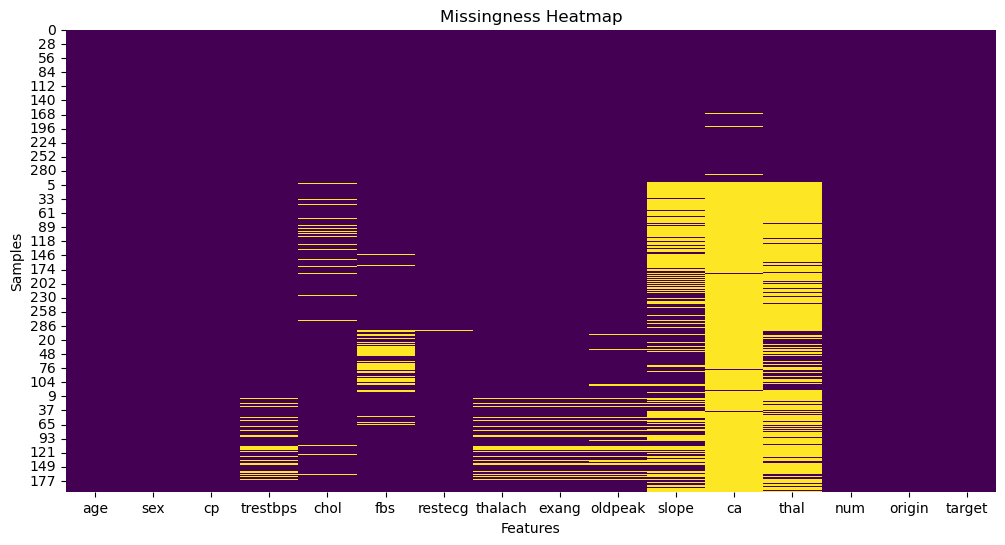

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Missingness Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_combined.isnull(), cbar=False, cmap='viridis')
plt.title('Missingness Heatmap')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

In [8]:
missing_counts_by_origin = df_combined.groupby("origin").apply(lambda g: g.isna().sum())

<positron-console-cell-8>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


<positron-console-cell-9>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



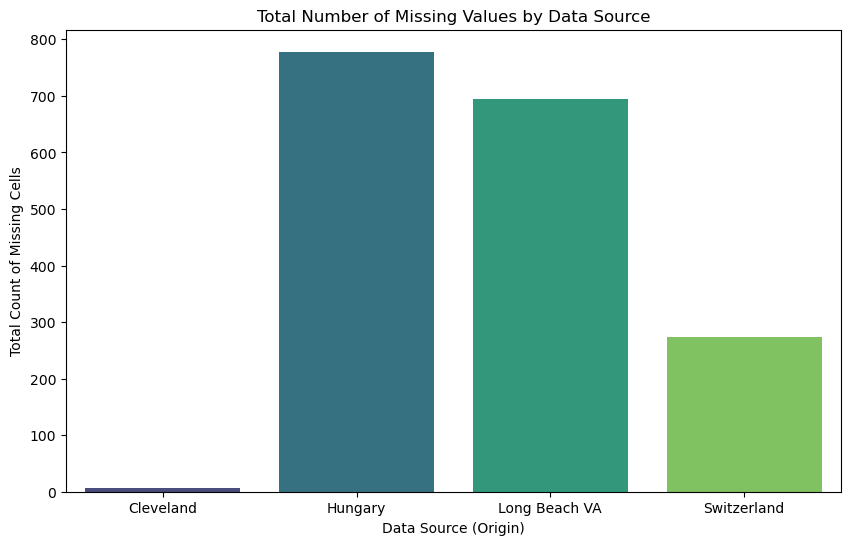

In [9]:
# First, let's get the total number of missing values for each origin by summing across the columns (axis=1)
total_missing_by_origin = missing_counts_by_origin.sum(axis=1)

# Now, let's create a bar plot to visualize these totals
plt.figure(figsize=(10, 6))
sns.barplot(x=total_missing_by_origin.index, y=total_missing_by_origin.values, palette="viridis")
plt.title('Total Number of Missing Values by Data Source')
plt.xlabel('Data Source (Origin)')
plt.ylabel('Total Count of Missing Cells')
plt.show()

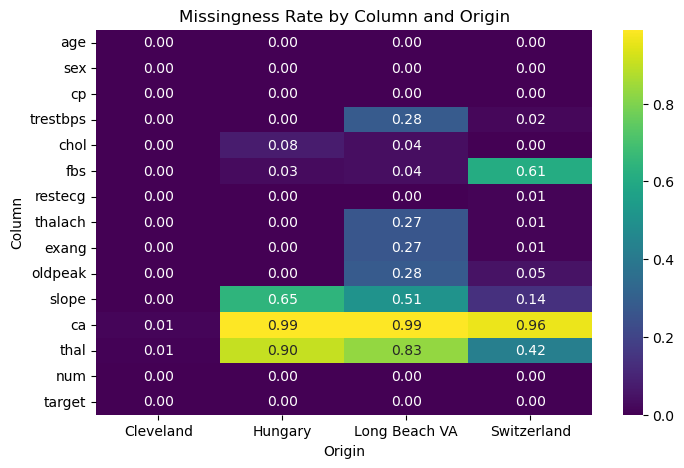

In [10]:
num_cols = df_combined.select_dtypes(include=[np.number]).columns.tolist()
miss_by_origin = df_combined.groupby("origin")[num_cols].apply(lambda g: g.isna().mean()).T

plt.figure(figsize=(8,5))
sns.heatmap(miss_by_origin, cmap="viridis", annot=True, fmt=".2f")
plt.title("Missingness Rate by Column and Origin")
plt.xlabel("Origin"); plt.ylabel("Column")
plt.show()


In [11]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

def simple_impute(df):
    df2 = df.copy()

    num_cols = df2.select_dtypes(include=[np.number]).columns
    cat_cols = df2.select_dtypes(exclude=[np.number]).columns

    if len(num_cols) > 0:
        num_imp = SimpleImputer(strategy="mean")
        df2[num_cols] = num_imp.fit_transform(df2[num_cols])

    if len(cat_cols) > 0:
        cat_imp = SimpleImputer(strategy="most_frequent")
        df2[cat_cols] = cat_imp.fit_transform(df2[cat_cols])

    return df2

df_cleveland_simple = simple_impute(df_cleveland)
df_hungary_simple = simple_impute(df_hungary)
df_switzerland_simple = simple_impute(df_switzerland)
df_long_beach_va_simple = simple_impute(df_long_beach_va)

df_combined_simple = pd.concat([df_cleveland_simple, df_hungary_simple, df_switzerland_simple, df_long_beach_va_simple])

In [12]:
from sklearn.impute import KNNImputer
import pandas as pd

CONT_NUM = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"] # continuous / discrete numeric features
CAT_CODE = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"] # coded categoricals

def knn_impute(df, n_neighbors=5):
    df2 = df.copy()

    # Only use true feature columns for distances (exclude the outcome and its proxy)
    knn_cols = [c for c in CONT_NUM if c in df2.columns] # numeric to KNN-impute
    cat_cols = [c for c in CAT_CODE if c in df2.columns] # categoricals to mode-impute

    # KNN for continuous numerics (no label columns in distance)
    if knn_cols:
        knn = KNNImputer(n_neighbors=n_neighbors, weights="uniform")
        df2[knn_cols] = knn.fit_transform(df2[knn_cols])

    # Most-frequent for categoricals (keeps valid codes)
    if cat_cols:
        cat_imp = SimpleImputer(strategy="most_frequent")
        df2[cat_cols] = cat_imp.fit_transform(df2[cat_cols])

    return df2

df_cleveland_knn = knn_impute(df_cleveland, n_neighbors=5)
df_hungary_knn = knn_impute(df_hungary, n_neighbors=5)
df_switzerland_knn = knn_impute(df_switzerland, n_neighbors=5)
df_long_beach_va_knn = knn_impute(df_long_beach_va, n_neighbors=5)

df_combined_knn = pd.concat(
    [df_cleveland_knn, df_hungary_knn, df_switzerland_knn, df_long_beach_va_knn],
    ignore_index=True
)

In [13]:
# Binary columns -> 0/1
bin_cols = ["sex", "fbs", "exang", "target"]
for c in bin_cols:
    if c in df_combined_knn.columns:
        df_combined_knn[c] = (df_combined_knn[c].clip(0,1) >= 0.5).astype("Int64")

# Ordinal/ranged codes
range_cols = {
    "cp": (1, 4),
    "restecg": (0, 2),
    "slope": (1, 3),
    "ca": (0, 3),
    "num": (0, 4),
}
for c, (lo, hi) in range_cols.items():
    if c in df_combined_knn.columns:
        df_combined_knn[c] = df_combined_knn[c].round().clip(lo,hi).astype("Int64")

# thal must be one of {3, 6, 7}
if "thal" in df_combined_knn.columns:
    allowed = np.array([3, 6, 7])
    df_combined_knn["thal"] = df_combined_knn["thal"].apply(
        lambda v: int(allowed[np.argmin(np.abs(allowed - v))]) if pd.notna(v) else pd.NA
    ).astype("Int64")

# Convert age to Int64
if "age" in df_combined_knn.columns:
    df_combined_knn["age"] = df_combined_knn["age"].round().clip(lower=0).astype("Int64")


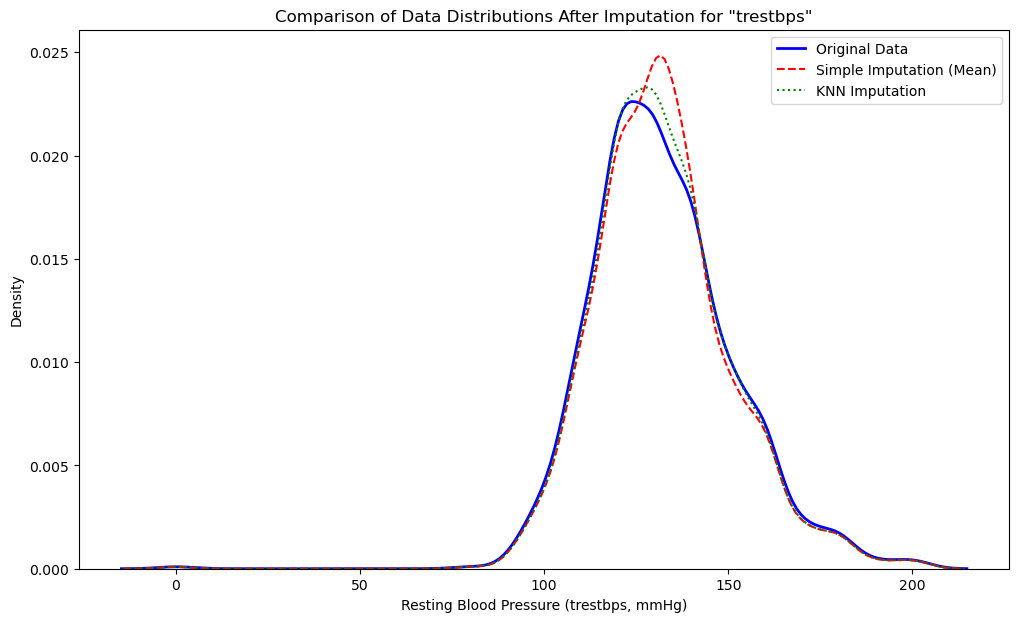

In [14]:
# Set up the plot
plt.figure(figsize=(12, 7))

# Plot the distribution of the original data (where it's not missing)
# We use a kernel density estimate (kde) plot, which is like a smooth histogram.
sns.kdeplot(df_combined['trestbps'].dropna(), label='Original Data', color='blue', linewidth=2)

# Plot the distribution of the data after Simple Imputation
sns.kdeplot(df_combined_simple['trestbps'], label='Simple Imputation (Mean)', color='red', linestyle='--')

# Plot the distribution of the data after KNN Imputation
sns.kdeplot(df_combined_knn['trestbps'], label='KNN Imputation', color='green', linestyle=':')

# Add titles and labels for clarity
plt.title('Comparison of Data Distributions After Imputation for "trestbps"')
plt.xlabel("Resting Blood Pressure (trestbps, mmHg)")
plt.ylabel('Density')
plt.legend()
plt.show()

<positron-console-cell-15>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



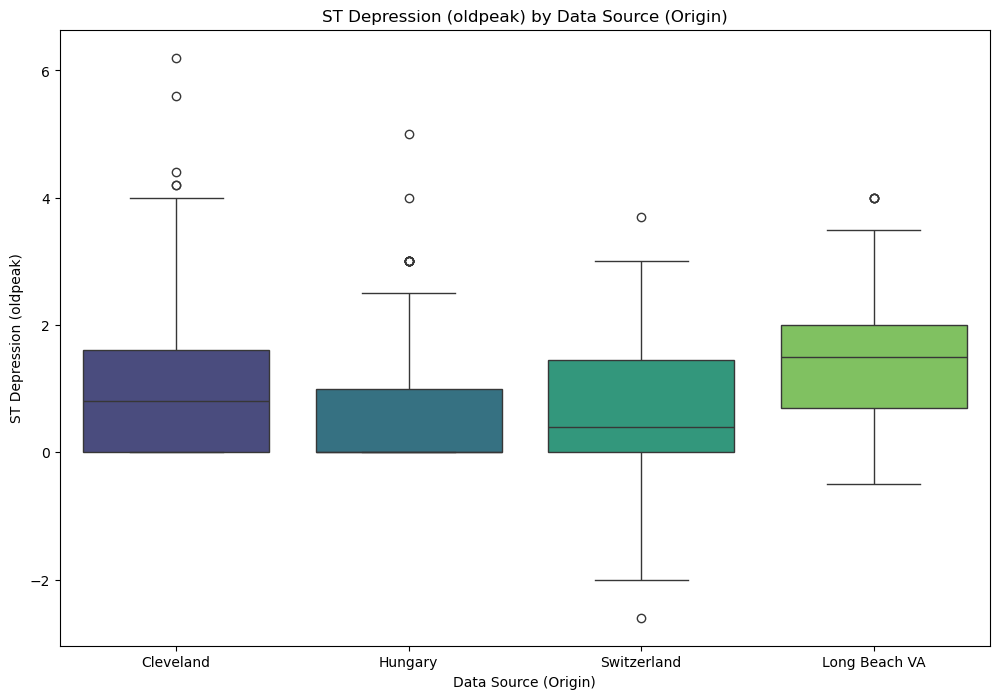

In [15]:
df_final = df_combined_knn

# Set up the plot with a larger size for clarity
plt.figure(figsize=(12, 8))

# Create a box plot using seaborn
# We will use your best dataset: df_final
sns.boxplot(data=df_final, x='origin', y='oldpeak', palette='viridis')

# Add titles and labels
plt.title("ST Depression (oldpeak) by Data Source (Origin)")
plt.xlabel('Data Source (Origin)')
plt.ylabel('ST Depression (oldpeak)')
plt.show()

In [16]:
df_final.describe(include='all')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,origin,target
count,918.0,918.0,918.0,918.000000,918.000000,918.0,918.0,918.000000,918.0,918.000000,918.0,918.0,918.0,918.0,918,918.0
unique,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,4,<NA>
top,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,Cleveland,<NA>
freq,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,303,<NA>
mean,53.510893,0.78976,3.251634,132.143137,200.379085,0.150327,0.603486,136.812636,0.423747,0.909434,1.847495,0.489107,6.087146,0.995643,NaN,0.553377
std,9.432617,0.407701,0.931031,18.617723,109.629905,0.357586,0.805968,25.467068,0.494421,1.067998,0.51652,0.854388,1.634226,1.142985,NaN,0.497414
min,28.0,0.0,1.0,0.000000,0.000000,0.0,0.0,60.000000,0.0,-2.600000,1.0,0.0,3.0,0.0,NaN,0.0
25%,47.0,1.0,3.0,120.000000,177.000000,0.0,0.0,120.000000,0.0,0.000000,2.0,0.0,6.0,0.0,NaN,0.0
50%,54.0,1.0,4.0,130.000000,224.000000,0.0,0.0,138.000000,0.0,0.700000,2.0,0.0,7.0,1.0,NaN,1.0
75%,60.0,1.0,4.0,140.000000,268.750000,0.0,1.0,155.750000,1.0,1.530000,2.0,1.0,7.0,2.0,NaN,1.0


In [17]:
df_final.groupby("origin")[["age","trestbps","chol","thalach","oldpeak"]].describe().round(2)

age                           ... oldpeak                     
               count   mean   std   min   25%  ...     min  25%  50%   75%  max
origin                                         ...                             
Cleveland      303.0  54.44  9.04  29.0  48.0  ...     0.0  0.0  0.8  1.60  6.2
Hungary        293.0  47.82  7.82  28.0  42.0  ...     0.0  0.0  0.0  1.00  5.0
Long Beach VA  199.0  59.36  7.83  35.0  55.0  ...    -0.5  0.7  1.5  2.00  4.0
Switzerland    123.0  55.32  9.03  32.0  51.0  ...    -2.6  0.0  0.4  1.45  3.7

[4 rows x 40 columns]

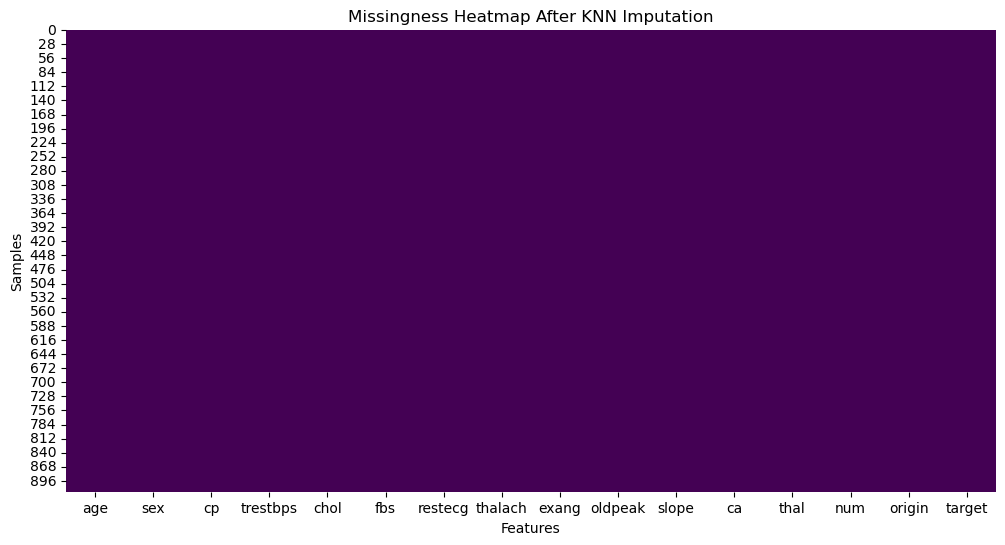

In [18]:
# Missingness Heatmap Imputed
plt.figure(figsize=(12, 6))
sns.heatmap(df_final.isnull(), cbar=False, cmap='viridis')
plt.title('Missingness Heatmap After KNN Imputation')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

In [19]:
cp_map = pd.DataFrame({
    "cp": [1, 2, 3, 4],
    "cp_label": ["typical angina", "atypical angina", "non-anginal pain", "asymptomatic"]
})

restecg_map = pd.DataFrame({
    "restecg": [0, 1, 2],
    "restecg_label": ["normal", "ST–T wave abnormality (>0.05 mV)", "LVH by Estes"]
})

slope_map = pd.DataFrame({
    "slope": [1, 2, 3],
    "slope_label": ["upsloping", "flat", "downsloping"]
})

thal_map = pd.DataFrame({
    "thal": [3, 6, 7],
    "thal_label": ["normal", "fixed defect", "reversible defect"]
})

num_map = pd.DataFrame({
    "num": [0, 1, 2, 3, 4],
    "num_label": ["no heart disease", "mild heart disease", "moderate heart disease", "severe heart disease", "critical heart disease"]
})

df_final = (df_final
    .merge(cp_map, on="cp", how="left")
    .merge(restecg_map, on="restecg", how="left")
    .merge(slope_map, on="slope", how="left")
    .merge(thal_map, on="thal", how="left")
    .merge(num_map, on="num", how="left")
)


In [20]:
# Combined Dataset
df_final.to_csv("combined_clean.csv", index=False)

All the analysis is contained in analysis.py. This notebook is just an extra for better display of results.